In [1]:
#@title Initial Colab setup...

# remove colab sample_data
!rm -rf sample_data/

# download datasets
!rm -rf /tmp/sf-lab; git clone https://github.com/sysflow-telemetry/sf-lab.git /tmp/sf-lab

# add symlink to working directory
!unlink data; ln -s /tmp/sf-lab/pynb/data data
!unlink policies; ln -s /tmp/sf-lab/pynb/policies policies

# install sysflow tooling
!pip install sysflow-tools==0.5.1rc4

Cloning into '/tmp/sf-lab'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 162 (delta 13), reused 24 (delta 7), pack-reused 131
Receiving objects: 100% (162/162), 16.16 MiB | 5.84 MiB/s, done.
Resolving deltas: 100% (81/81), done.
Updating files: 100% (40/40), done.
unlink: cannot unlink 'data': Is a directory
ln: failed to create symbolic link 'data/data': File exists
unlink: cannot unlink 'policies': Is a directory
ln: failed to create symbolic link 'policies/policies': File exists
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 758.6 kB/s eta 0:00:00 0:00:01
  Attempting uninstall: sysflow-tools
    Found existing installation: sysflow-tools 0.6.1
    Uninstalling sysflow-tools-0.6.1:
      Successfully uninstalled sysflow-tools-0.6.1


In [2]:
import sys, os, json
import numpy as np
import pandas as pd
from sysflow.graphlet import Graphlet
from sysflow.reader import FlattenedSFReader
from sysflow.formatter import SFFormatter
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)
cols=['ts_uts', 'endts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'pproc.args', 'res', 'flow.rbytes', 'flow.rops', 'flow.wbytes', 'flow.wops', 'container.id', 'tags']
_cols=['ts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'tags']
evtcols=['ts_uts', 'type', 'opflags', 'proc.pid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'pproc.args', 'container.id', 'tags']
entry='proc.aname contains /bin/bash'
_entry='proc.aname contains apache2'

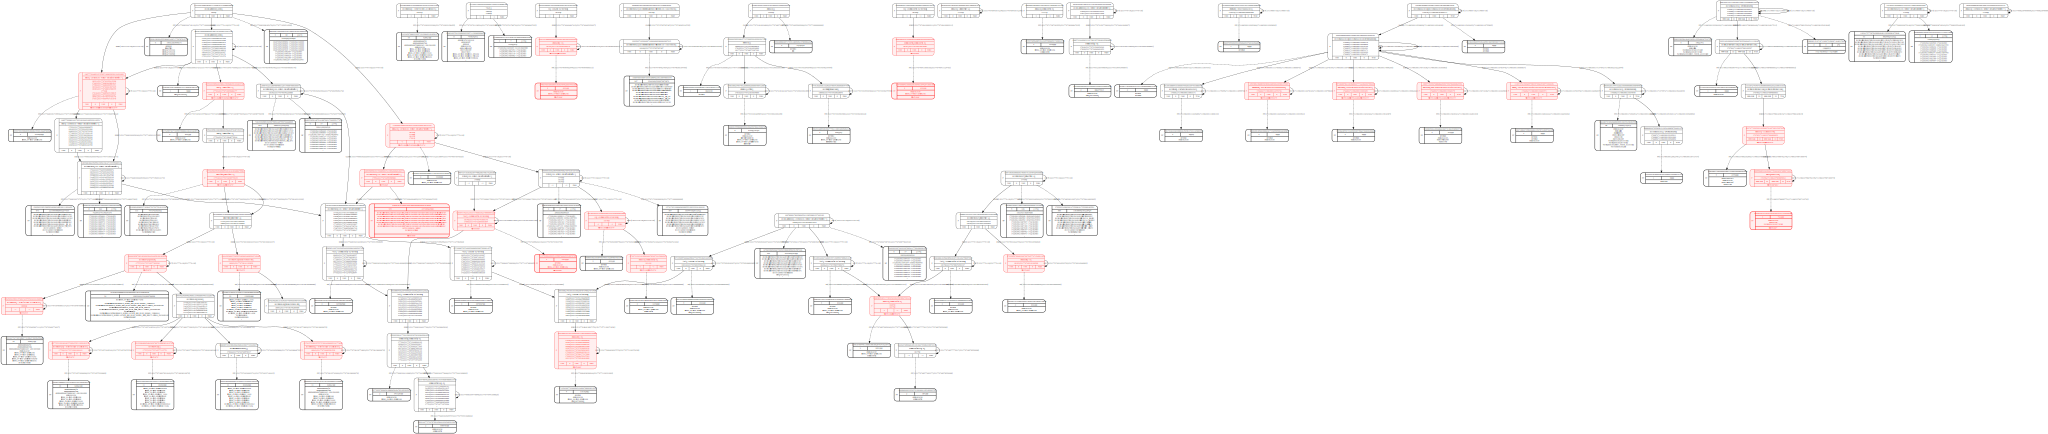

In [3]:
# graphlet showing client2's node.js server exploit with TTP tagging.
ioc = '(proc.cmdline contains exfil or (type = FF and file.path contains exfil and flow.wbytes > 0)) and proc.aname contains node and proc.exe!=/bin/dash'
gn = Graphlet('data/attacks/express',defs=['policies/ttps.yaml']) #Graphlet(<file>, ['policies/ttps.yaml'])
gn.view(withoid=True, peek=True, peeksize=10, flows=True, ttps=True)

In [4]:
_ioc = 'proc.cmdline contains exfil or proc.aname contains exfil'
gm = Graphlet('data/attacks/express/1711486262',defs = ['policies/ttps.yaml'])
gm.data()[_cols]

ts_uts type      opflags  proc.pid  proc.tid  pproc.pid              proc.exe                          proc.args             pproc.exe tags
0    1.711486e+18   FF          C      176679  176679.0     176678            /bin/mkdir                -p /var/run/apache2  /usr/sbin/apache2ctl   ()
1    1.711486e+18   FF          C      176679  176679.0     176678            /bin/mkdir                -p /var/run/apache2  /usr/sbin/apache2ctl   ()
2    1.711486e+18   PE         EXIT    176679  176679.0     176678            /bin/mkdir                -p /var/run/apache2  /usr/sbin/apache2ctl   ()
3    1.711486e+18   PE        CLONE    176680  176680.0     176678  /usr/sbin/apache2ctl  /usr/sbin/apache2ctl -DFOREGROUND  /usr/sbin/apache2ctl   ()
4    1.711486e+18   FF  O       C      176680  176680.0     176678  /usr/sbin/apache2ctl  /usr/sbin/apache2ctl -DFOREGROUND  /usr/sbin/apache2ctl   ()
..            ...  ...          ...       ...       ...        ...                   ...                                ...                   ...  ...
180  1.711486e+18   PE         EXIT    176687  176687.0     176686     /usr/sbin/apache2                       -DFOREGROUND     /usr/sbin/apache2   ()
181           NaN    P                 176679       NaN     176678            /bin/mkdir                -p /var/run/apache2  /usr/sbin/apache2ctl   ()
182           NaN    P                 176678       NaN     176655  /usr/sbin/apache2ctl  /usr/sbin/apache2ctl -DFOREGROUND              /main.sh   ()
183           NaN    P                 176688       NaN     176686     /usr/sbin/apache2                       -DFOREGROUND     /usr/sbin/apache2   ()
184           NaN    P                 176687       NaN     176686     /usr/sbin/apache2                       -DFOREGROUND     /usr/sbin/apache2   ()

[185 rows x 10 columns]

In [24]:
type(gm)

sysflow.graphlet.Graphlet

In [5]:
# Here we use the tags to retrieve the corresponding technique, tactics, etc. from MITRE via STIX/TAXII. 
gn.ttps()

ID                                                                                                    name                                            url                                             tactics                                                                  platforms
0      T1106                                                                                              Native API      https://attack.mitre.org/techniques/T1106                                           Execution                                                      Linux, Windows, macOS
1  T1059.004                                                           Command and Scripting Interpreter: Unix Shell  https://attack.mitre.org/techniques/T1059/004                                           Execution                                                               Linux, macOS
2      T1574                                                                                   Hijack Execution Flow      https://attack.mitre.org/techniques/T1574  Defense Evasion, Persistence, Privilege Escalation                                                      Linux, Windows, macOS
3      T1068                                                                   Exploitation for Privilege Escalation      https://attack.mitre.org/techniques/T1068                                Privilege Escalation                                          Containers, Linux, Windows, macOS
4      T1082                                                                            System Information Discovery      https://attack.mitre.org/techniques/T1082                                           Discovery                                       IaaS, Linux, Network, Windows, macOS
5      T1072                                                                               Software Deployment Tools      https://attack.mitre.org/techniques/T1072                         Execution, Lateral Movement                                             Linux, Network, Windows, macOS
6  T1222.002  File and Directory Permissions Modification: Linux and Mac File and Directory Permissions Modification  https://attack.mitre.org/techniques/T1222/002                                     Defense Evasion                                                               Linux, macOS
7  T1087.001                                                                        Account Discovery: Local Account  https://attack.mitre.org/techniques/T1087/001                                           Discovery                                                      Linux, Windows, macOS
8      T1087                                                                                       Account Discovery      https://attack.mitre.org/techniques/T1087                                           Discovery  Azure AD, Google Workspace, IaaS, Linux, Office 365, SaaS, Windows, macOS

In [6]:
ttps = gn.data()[_cols]
ttps[ttps.tags != ()]

ts_uts type      opflags  proc.pid proc.tid pproc.pid    proc.exe                                           proc.args                    pproc.exe                                                                                                                              tags
76     1531776683301636352.0   PE         EXEC     17459  17459.0      2025     /bin/sh  -c python cos-write.py -p testat:foo:"ibm 4 life!"          /usr/local/bin/node                   ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1106, mitre:T1059.004, mitre:T1574}, 3)
537    1531776683644972032.0   PE         EXEC     17463  17463.0      2025     /bin/sh  -c python cos-write.py -p testat:foo:"ibm 4 life!"          /usr/local/bin/node                   ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1106, mitre:T1059.004, mitre:T1574}, 3)
1376     1531776684038327570   PE         EXEC     17468    17468     17467  /bin/uname                                                  -p                         <NA>                                                                                  ([SystemInformationDiscovery], {mitre:T1082}, 3)
1860     1531776684422695748   PE         EXEC     17471    17471     17470  /bin/uname                                                  -p                         <NA>                                                                                  ([SystemInformationDiscovery], {mitre:T1082}, 3)
1970   1531776685507394816.0   PE         EXEC     17485  17485.0      2025     /bin/sh  -c python cos-write.py -p testat:foo:"ibm 4 life!"          /usr/local/bin/node                   ([Suspiciousprocessspawned, Shellstartedbycontainerentrypoint], {mitre:T1106, mitre:T1059.004, mitre:T1574}, 3)
...                      ...  ...          ...       ...      ...       ...         ...                                                 ...                          ...                                                                                                                               ...
43308    1711486300114571538   PE         EXEC    176684   176684    176678  /bin/chown               www-data /var/lock/apache2.q9yG4eLwcL         /usr/sbin/apache2ctl  ([Suspiciousprocessspawned, LinuxandMacFileandDirectoryPermissionsModification], {mitre:T1106, mitre:T1222.002, mitre:T1574}, 3)
43320    1711486300115783478   PE         EXEC    176685   176685    176678     /bin/mv   -T /var/lock/apache2.q9yG4eLwcL /var/lock/apache2         /usr/sbin/apache2ctl                                                                       ([Suspiciousprocessspawned], {mitre:T1106, mitre:T1574}, 1)
43444    1711486337985164814   PE         EXEC    176785   176785    176784   /bin/bash                                  -c cat /etc/passwd  /usr/lib/cgi-bin/vulnerable                                                                       ([Suspiciousprocessspawned], {mitre:T1106, mitre:T1574}, 1)
43451    1711486337986792149   PE         EXEC    176785   176785    176784    /bin/cat                                         /etc/passwd  /usr/lib/cgi-bin/vulnerable                                                                           ([AccountDiscovery:LocalAccount], {mitre:T1087.001}, 3)
43453    1711486337987089407   FF  O   R   C      176785   176785    176784    /bin/cat                                         /etc/passwd  /usr/lib/cgi-bin/vulnerable                                                                                  ([Untrustedreadsensitivefile], {mitre:T1087}, 2)

[557 rows x 10 columns]

In [7]:
# Here we summarize the unique set of mitigations corresponding to the ttps oberved in graphlet.
gn.mitigations()

ID                                     name                                         url
0   M1040          Behavior Prevention on Endpoint  https://attack.mitre.org/mitigations/M1040
1   M1038                     Execution Prevention  https://attack.mitre.org/mitigations/M1038
2   M1013           Application Developer Guidance  https://attack.mitre.org/mitigations/M1013
3   M1047                                    Audit  https://attack.mitre.org/mitigations/M1047
4   M1022  Restrict File and Directory Permissions  https://attack.mitre.org/mitigations/M1022
5   M1044                 Restrict Library Loading  https://attack.mitre.org/mitigations/M1044
6   M1024            Restrict Registry Permissions  https://attack.mitre.org/mitigations/M1024
7   M1051                          Update Software  https://attack.mitre.org/mitigations/M1051
8   M1052                     User Account Control  https://attack.mitre.org/mitigations/M1052
9   M1018                  User Account Management  https://attack.mitre.org/mitigations/M1018
10  M1048     Application Isolation and Sandboxing  https://attack.mitre.org/mitigations/M1048
11  M1050                       Exploit Protection  https://attack.mitre.org/mitigations/M1050
12  M1019              Threat Intelligence Program  https://attack.mitre.org/mitigations/M1019
13  M1015           Active Directory Configuration  https://attack.mitre.org/mitigations/M1015
14  M1033              Limit Software Installation  https://attack.mitre.org/mitigations/M1033
15  M1032              Multi-factor Authentication  https://attack.mitre.org/mitigations/M1032
16  M1030                     Network Segmentation  https://attack.mitre.org/mitigations/M1030
17  M1027                        Password Policies  https://attack.mitre.org/mitigations/M1027
18  M1026            Privileged Account Management  https://attack.mitre.org/mitigations/M1026
19  M1029                      Remote Data Storage  https://attack.mitre.org/mitigations/M1029
20  M1017                            User Training  https://attack.mitre.org/mitigations/M1017
21  M1028           Operating System Configuration  https://attack.mitre.org/mitigations/M1028

In [8]:
trace="data/attacks/express/1711486262"
reader = FlattenedSFReader(trace)
formatter = SFFormatter(reader)
cdf = formatter.toDataframe()
cdf.loc['wcm-app', 'container.name'] = 'app'
cdf.loc['wcm-squid', 'container.name'] = 'node.js'

In [9]:
container_type =  cdf.groupby(['container.name','proc.exe','proc.args','pproc.exe','type','res']).size().reset_index(name='count')
cluster = px.treemap(container_type, path=['container.name','proc.exe','type','res'], values='count',
                  color='type', 
                  hover_data=['container.name','proc.exe','proc.args','pproc.exe','type','res'], 
                  color_discrete_sequence=px.colors.qualitative.Plotly)  

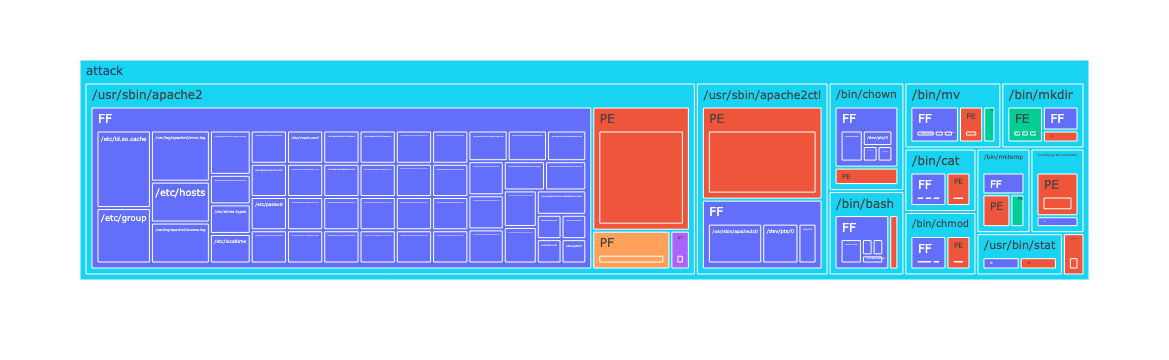

In [10]:
cluster.show()

In [11]:
trace="data/attacks/express/1711486262"
reader = FlattenedSFReader(trace)
formatter = SFFormatter(reader)
nf = formatter.toDataframe()

In [12]:
from IPython.display import display

In [13]:
containerNF = nf[nf['type'] == 'NF']
display(containerNF)
containerNF =  containerNF.groupby(['container.name','net.sport','net.sip','net.dport', 'net.dip']).size().reset_index(name='count')
containerNF.loc[containerNF['net.sport'] > 40000, 'net.sport'] = 40001
containerNF['net.sport'] = containerNF['net.sport'].mask(containerNF['net.sport'].between(1024, 40000))
containerNF['net.sport'] = containerNF['net.sport'].replace(np.nan, '1024-40000', regex=True)
containerNF['net.sport'] = containerNF['net.sport'].replace(40001, '40001+', regex=True)

nf = px.parallel_categories(containerNF, dimensions=['container.name','net.sport', 'net.sip', 'net.dport', 'net.dip'],
                color="net.dport", color_continuous_scale=px.colors.sequential.PuBuGn
                )

version type     state      opflags  opflags_bitmap  ret                          ts               ts_uts                       endts     endts_uts  proc.pid  proc.tid  proc.uid proc.user  proc.gid proc.group proc.cwd           proc.exe     proc.args  proc.tty  proc.entry                                                                                                                                                                                                                                                                                                                                  proc.env        proc.createts  pproc.pid  pproc.gid  pproc.uid pproc.group pproc.tty pproc.entry                                                                                                                                           pproc.env pproc.user pproc.cwd          pproc.exe    pproc.args       pproc.createts file.fd file.path file.newpath file.type file.openflags net.proto  net.sport  net.dport     net.sip     net.dip                             res  flow.rbytes  flow.rops  flow.wbytes  flow.wops  pf.nthreads  pf.nexits  pf.nerrors  container.id container.name                                                 container.imageid                   container.image container.type  container.privileged pod.id pod.name pod.nname pod.hostip pod.internalip pod.ns pod.rstrtcnt pod.services                   node.id node.ip                   filename  schema tags k8s.action k8s.kind k8s.msg
201       4   NF  MODIFIED     WR  SC              5888  NaN  2024-03-26T20:52:17.982152  1711486337982152434  2024-03-26T20:52:18.125422  1.711486e+18    176688  176691.0        33  www-data        33   www-data        /  /usr/sbin/apache2  -DFOREGROUND      True       False  HOSTNAME=329f1f136bbb;SHLVL=1;APACHE_RUN_DIR=/var/run/apache2;APACHE_PID_FILE=/var/run/apache2.pid;_=/usr/sbin/apache2ctl;TERM=xterm;PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin;APACHE_LOCK_DIR=/var/lock/apache2;LANG=C;APACHE_RUN_USER=www-data;APACHE_RUN_GROUP=www-data;APACHE_LOG_DIR=/var/log/apache2;PWD=/  1711486300130241066   176686.0        0.0        0.0        root      True       False  HOSTNAME=329f1f136bbb;TERM=xterm;PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin;PWD=/;SHLVL=1;HOME=/root;_=/usr/sbin/apache2ctl       root         /  /usr/sbin/apache2  -DFOREGROUND  1711486300116934649      10                                                         6    49152.0       80.0  172.17.0.1  172.17.0.3  172.17.0.1:49152-172.17.0.3:80        138.0        4.0        895.0        3.0          NaN        NaN         NaN  329f1f136bbb         attack  790a145cf22fe2800d25727c2796619b7235c9b144e752a3d9a91fdaadf513ba  vulnerables/cve-2014-6271:latest      CT_DOCKER                 False                                                                    None               golang.sl.cloud9.ibm.com          /mnt/data/rcos/1711486262       5   ()

In [14]:
containerNF

container.name net.sport     net.sip  net.dport     net.dip  count
0         attack    40001+  172.17.0.1       80.0  172.17.0.3      1

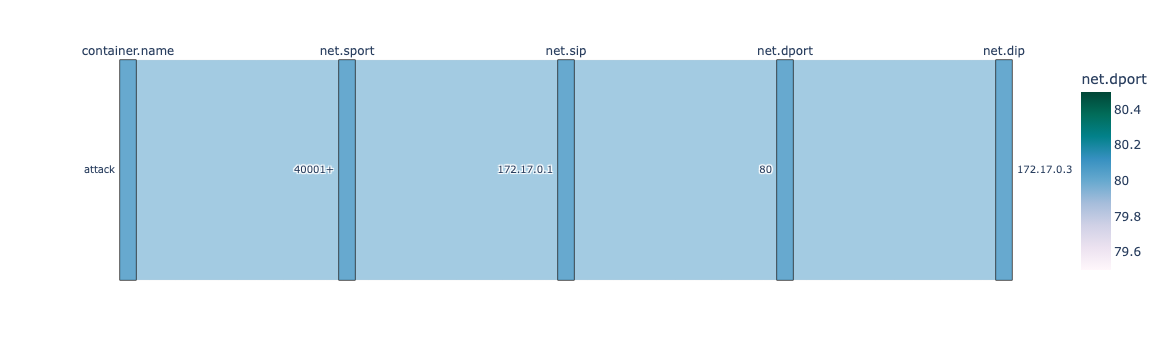

In [15]:
nf.show()

In [16]:
df = gm.data()

In [17]:
command_types = []

#Iterate over each row of the DataFrame
for index, row in df.iterrows():
    #Extract command type from proc.exe and proc.args columns
    command_type_exe = row['proc.exe'].split('/')[-1]
    command_type_args = row['proc.args'].split('/')[-1]
    
    if command_type_exe.strip():
        command_types.append(command_type_exe)
    else:
        command_types.append(command_type_args)

In [18]:
_cols = ['ts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'pproc.pid', 'proc.exe', 'proc.args', 'pproc.exe', 'tags']

#Extract the specified columns
selected_data = df[_cols]

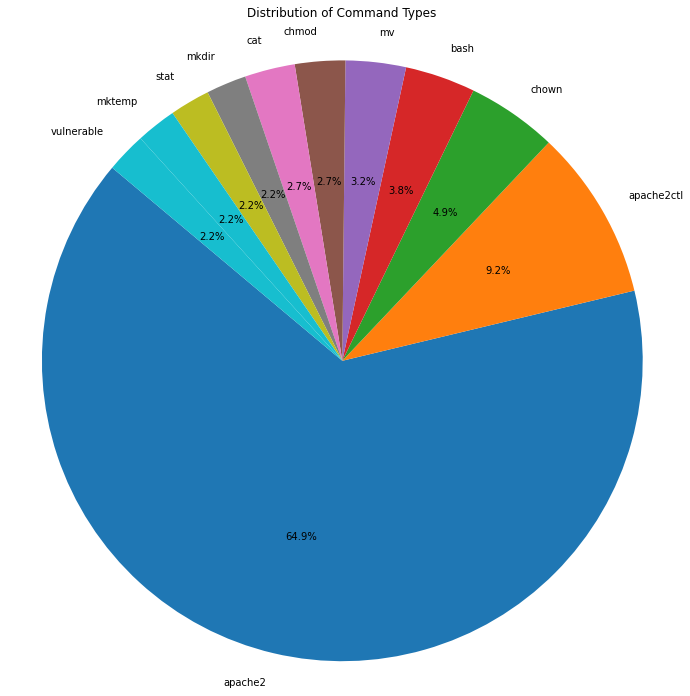

In [30]:
command_type_counts = pd.Series(command_types).value_counts()

#I originally ran into an issue where some colors overlapping right next to eachother so this should solve it 
num_colors = len(command_type_counts)
color_map = plt.cm.get_cmap('tab10', num_colors)

#Creating a pie chart of all the commands used
plt.figure(figsize=(12, 12))
command_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=color_map(range(num_colors)))
plt.title('Distribution of Command Types',pad=20)
plt.ylabel('')
plt.axis('equal')  #Equal aspect ratio should force this to be a circle
plt.xticks(fontsize=12)
plt.show()

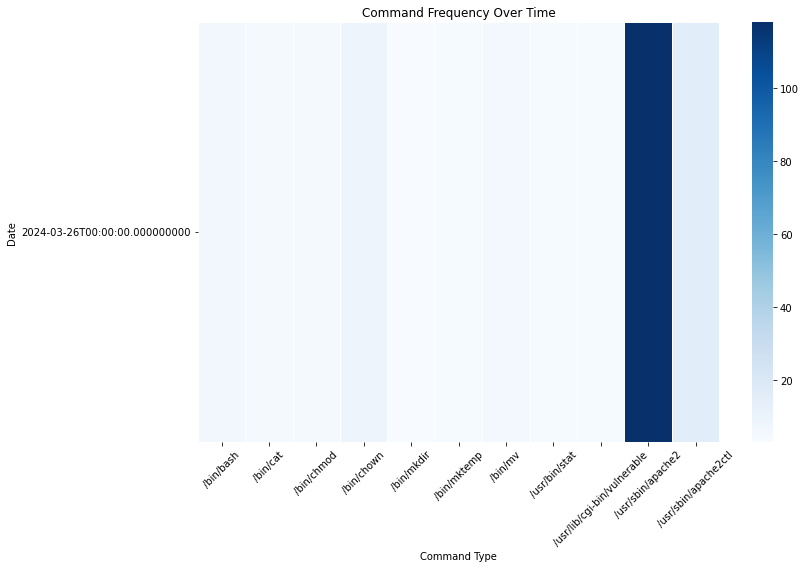

In [32]:
df['ts_uts'] = pd.to_datetime(df['ts_uts'])

#Group the data by command types and timestamps, and count occurrences
heatmap_data = df.groupby([pd.Grouper(key='ts_uts', freq='D'), 'proc.exe']).size().unstack(fill_value=0)

#Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='Blues', linecolor='white', linewidth=1)
plt.title('Command Frequency Over Time')
plt.xlabel('Command Type')
plt.ylabel('Date')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

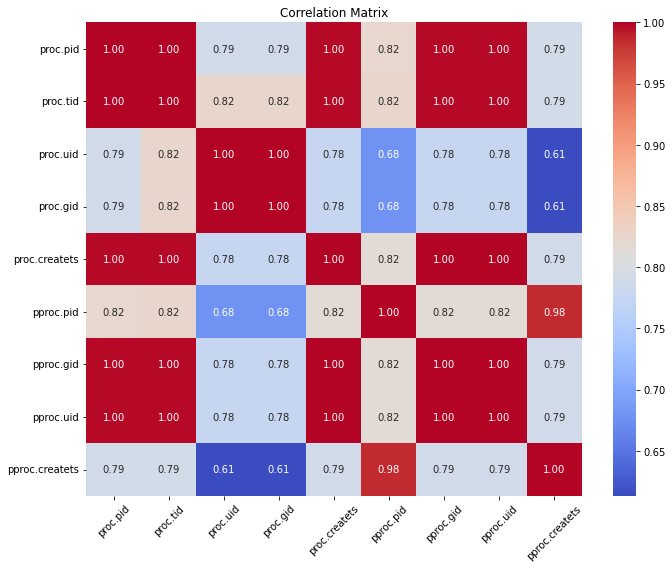

In [34]:
numeric_cols = df.select_dtypes(include='number')

correlation_matrix = numeric_cols.corr()

#This should create a correlation matrix between the different variables in the attack data
# It should visualize the relationships between them
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
import networkx as nx

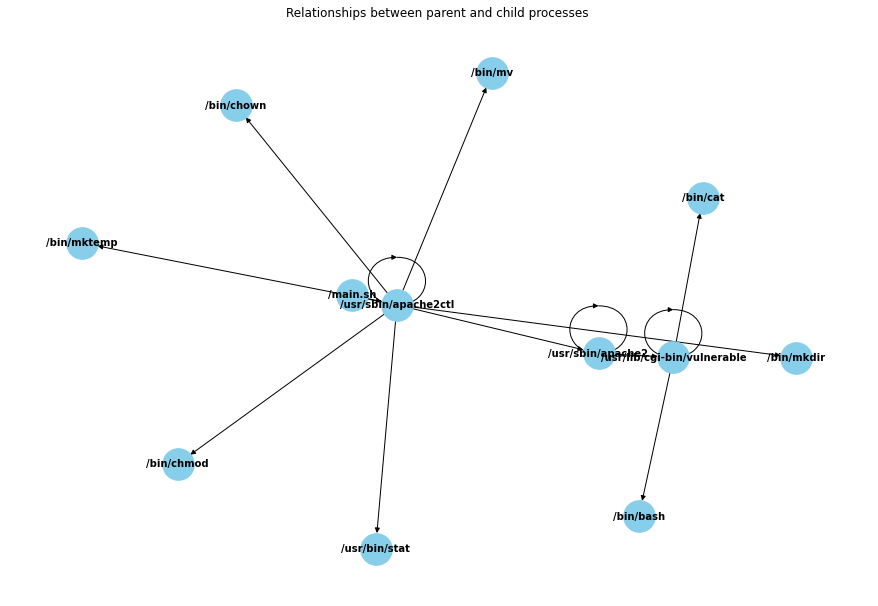

In [40]:
df2 = gm.data()

#This should create a directed graph
G = nx.DiGraph()

#I saw this used similarly but this will make a process tree, showing the relationships between parent and child processes 
for index, row in df2.iterrows():
    G.add_edge(row['pproc.exe'], row['proc.exe'])


plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold')
plt.title('Relationships between parent and child processes ')
plt.show()